# EWMA variance

A method for tracking variance over time while giving more importance to recent observations using an exponential decay factor.  

### **Key Ideas**  
- Recent data matters more than older data.  
- Fading factor ( $\alpha$ ) determines how fast older data is "forgotten".
- Variance is updated based on the deviation between the current and previous values.  

### **Mathematical Formulation**  
For a sequence of observations ( $x_t$ ) and initial $weight\_sum = 1$:  

1. **Exponentially Weighted Mean (EWA):**  
   $$
   \text{weight} = (1 - \alpha) \cdot \text{weight\_sum}
   $$
   $$
   \mu_t = \frac{\text{weight} \cdot \mu_{t-1} + x_t}{\text{weight} + 1}
   $$
   where ( $\mu_t$ ) is the exponentially weighted average.  

2. **Exponentially Weighted Variance (EWV):**  
   $$
   \sigma^2_t = \frac{\text{weight} \cdot \sigma^2_{t-1} + (x_t - \mu_{t-1}) (x_t - \mu_t)}{\text{weight} + 1}
   $$
   where ( $\sigma^2_t$ ) is the exponentially weighted variance.  

**Requirements:**

!pip install river

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            },
                "weight": weight
}
```

A **mixture density**, such as the gaussion mixture $\sum_{i=1}^{K} w_i \mathcal{N}(Y_t | \mu_i, \sigma_i^2)$ allows for capturing multi-modal distributions and approximate more complex distributions.

![proba_forecast_v3](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v3.png?raw=true)


**Probabilistic Forecasting** is particularly valuable in supply chain management. Below are some interesting resources for a deeper understanding:  

- [Probabilistic Forecasting](https://www.lokad.com/probabilistic-forecasting-definition/) – Overview of probabilistic forecasting and its applications.  
- [Quantile Forecasting](https://www.lokad.com/quantile-regression-time-series-definition/) – Explanation of quantile-based forecasting methods.  
- **Evaluation Metrics:**  
  - [Continuous Ranked Probability Score (CRPS)](https://www.lokad.com/continuous-ranked-probability-score/)  
  - [Cross-Entropy](https://www.lokad.com/cross-entropy-definition/)  
  - [Pinball Loss](https://www.lokad.com/pinball-loss-function-definition/)

In [1]:
# Standard library imports
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

try:
    from birdgame.visualization.viz_predictions import plot_dove_predictions
except:
    # Trick to be on root directory (to remove in the future and use install birdgame)
    # Change the working directory to the root of the package
    root_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
    os.chdir(root_dir)
    
# Birdgame package imports
from birdgame.datasources.remotetestdata import remote_test_data_generator
from birdgame.datasources.livedata import live_data_generator

from birdgame.visualization.viz_fewvar import visualize_fewvar
from birdgame.visualization.viz_predictions import plot_dove_predictions
from birdgame.evaluation.normal_dist import compute_score_for_normal_dist
from birdgame.evaluation.utils import find_past_pdf, summarize_predictions

### Warm up example: FEWVar model

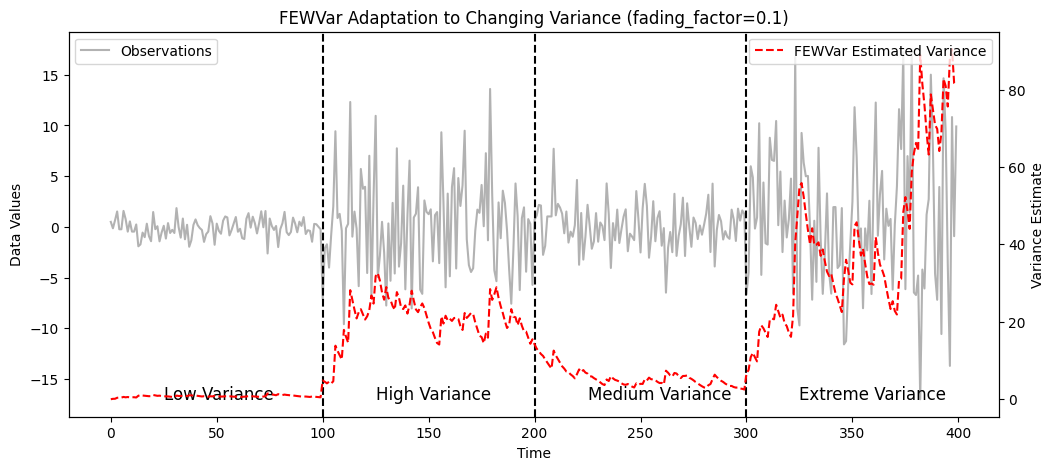

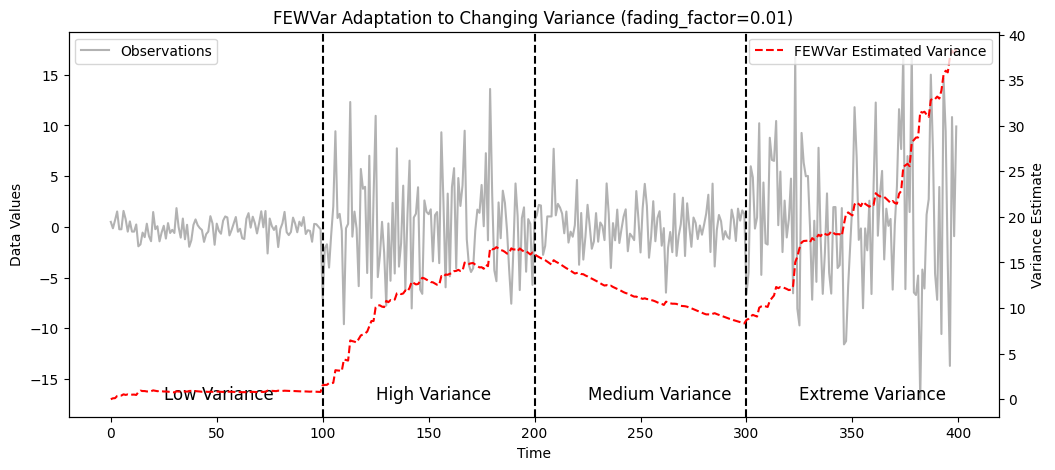

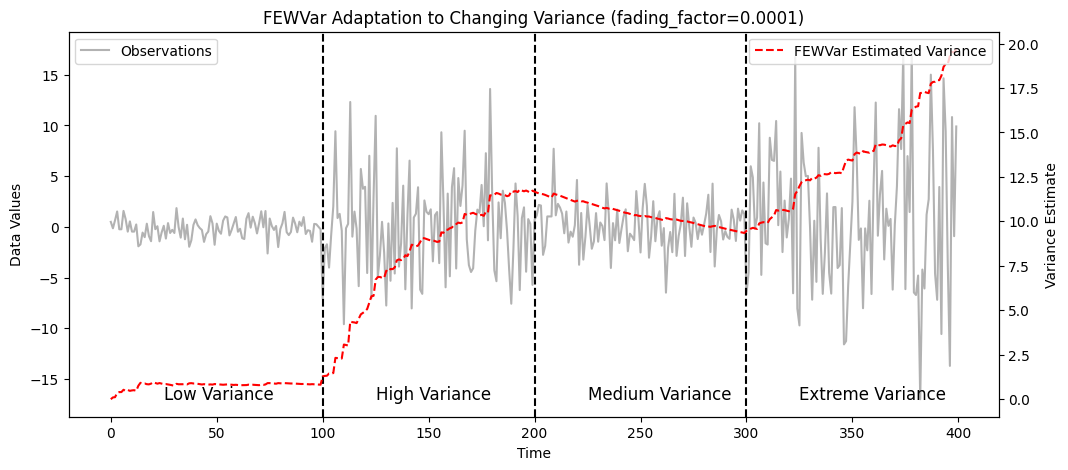

In [2]:
# Visualize FEWVar on synthetic data with different fading_factor values
list_fading_factor = [0.1, 0.01, 0.0001]
for factor in list_fading_factor:
    visualize_fewvar(fading_factor=factor, list_variances=[1, 5, 2, 8])

In [3]:
import math
import numpy as np
from birdgame.trackers.trackerbase import TrackerBase
from birdgame.stats.fewvar import FEWVar


class EMWAVarTracker(TrackerBase):
    """
    A model that fits a mixture of two Gaussian distributions, one capturing the core
    distribution and another with a larger variance to capture the tails.
    Using EWMA variance

    Parameters
    ----------
    fading_factor : float
        Parameter controlling how quickly older data is de-emphasized in variance estimation.
    horizon : int
        The "look-ahead" in time after which the recorded data becomes valid for updating.
    """

    def __init__(self, fading_factor=0.0001, horizon=10):
        super().__init__(horizon)
        self.fading_factor = fading_factor
        self.current_x = None
        self.ewa_dx_core = FEWVar(fading_factor=fading_factor)
        self.ewa_dx_tail = FEWVar(fading_factor=fading_factor)
        self.weights = [0.95, 0.05]  # Heavily weight the core distribution

    def tick(self, payload):
        """
        Ingest a new record (payload), store it internally and update the
        estimated Gaussian mixture model.

        The core distribution captures regular variance, while the tail distribution
        captures extreme deviations.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        """

        x = payload['dove_location']
        t = payload['time']
        self.add_to_quarantine(t, x)
        self.current_x = x
        prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:
            x_change = x - prev_x

            # Winsorize the update for the core estimator to avoid tail effects
            threshold = 2.0 * math.sqrt(self.ewa_dx_core.get() if self.count > 0 else 1.0)
            if threshold > 0:
                winsorized_x_change = np.clip(x_change, -threshold, threshold)
            else:
                winsorized_x_change = x_change
            self.ewa_dx_core.update(winsorized_x_change)

            # Feed the tail estimator with double the real change magnitude
            self.ewa_dx_tail.update(2.0 * x_change)

            self.count += 1

    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution,
        modeled as a mixture of two Gaussians.
        """
        # the central value (mean) of the gaussian distribution will be represented by the current value
        x_mean = self.current_x
        components = []

        for i, ewa_dx in enumerate([self.ewa_dx_core, self.ewa_dx_tail]):
            try:
                x_var = ewa_dx.get()
                x_std = math.sqrt(x_var)
            except:
                x_std = 1.0

            if x_std <= 1e-6:
                x_std = 1e-6

            components.append({
                "density": {
                    "type": "builtin",
                    "name": "norm",
                    "params": {"loc": x_mean, "scale": x_std}
                },
                "weight": self.weights[i]
            })

        prediction_density = {
            "type": "mixture",
            "components": components
        }
        return prediction_density

### Model experimentation

The model is experimented on a data generator using the following metric for a gaussian distribution:

$$\text{pdf\_score}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

This metric measures how well the predicted distribution aligns with the observed data. **A higher pdf_score indicates a more accurate prediction.**

### Run on a remote static data file

In [4]:
# Parameters
class Constants:
    HORIZON = 10
    FADE_FACTOR = 0.0001

# Initialize Tracker
tracker = EMWAVarTracker(fading_factor=Constants.FADE_FACTOR, horizon=Constants.HORIZON)

# Run on remote data
tracker.test_run(live=False)

0it [00:00, ?it/s]

My score: 45.1315 VS Benchmark score: 45.1315
My score: 40.4615 VS Benchmark score: 40.4615
My score: 36.1056 VS Benchmark score: 36.1056
My score: 36.2405 VS Benchmark score: 36.2405
My score: 35.8028 VS Benchmark score: 35.8028
My score: 35.8409 VS Benchmark score: 35.8409
My score: 34.9872 VS Benchmark score: 34.9872
My score: 34.0070 VS Benchmark score: 34.0070
My score: 32.9959 VS Benchmark score: 32.9959
My score: 32.0830 VS Benchmark score: 32.0830
My score: 31.6792 VS Benchmark score: 31.6792
My score: 31.1856 VS Benchmark score: 31.1856
My score: 30.5950 VS Benchmark score: 30.5950
My score: 30.5148 VS Benchmark score: 30.5148
My score: 30.5421 VS Benchmark score: 30.5421
My score: 30.2813 VS Benchmark score: 30.2813
My score: 30.2482 VS Benchmark score: 30.2482
My score: 30.2223 VS Benchmark score: 30.2223
My score: 30.1249 VS Benchmark score: 30.1249
My score: 29.9429 VS Benchmark score: 29.9429
My score: 29.8103 VS Benchmark score: 29.8103
My score: 29.7167 VS Benchmark sco

### Run on live data

In [ ]:
# Parameters
class Constants:
    HORIZON = 10
    FADE_FACTOR = 0.0001

# Initialize Tracker
tracker = EMWAVarTracker(fading_factor=Constants.FADE_FACTOR, horizon=Constants.HORIZON)

# Run on live data
tracker.test_run(live=True)
# Interrupt cell to stop run

0it [00:00, ?it/s]

Interrupted


### An animated run

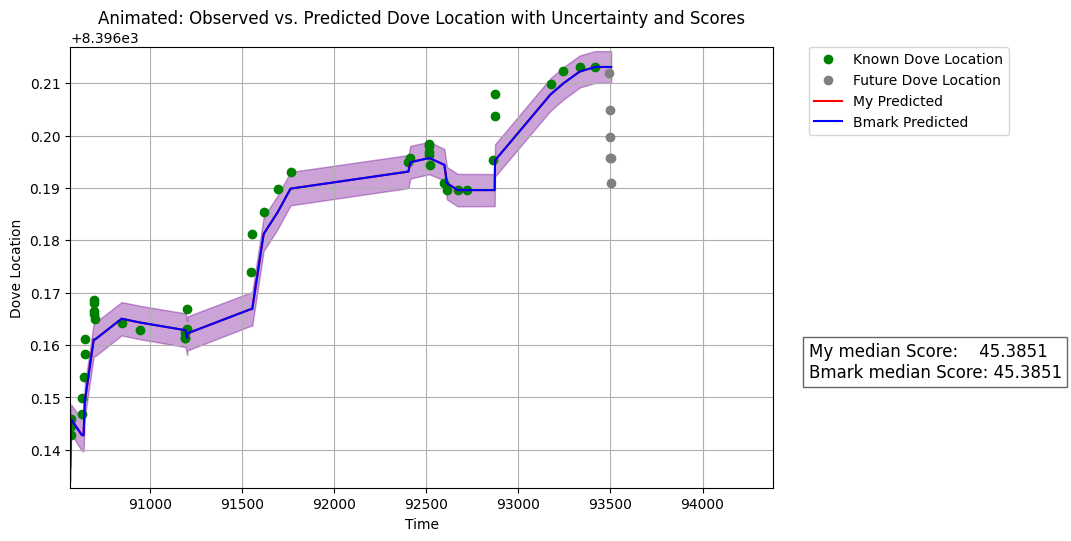

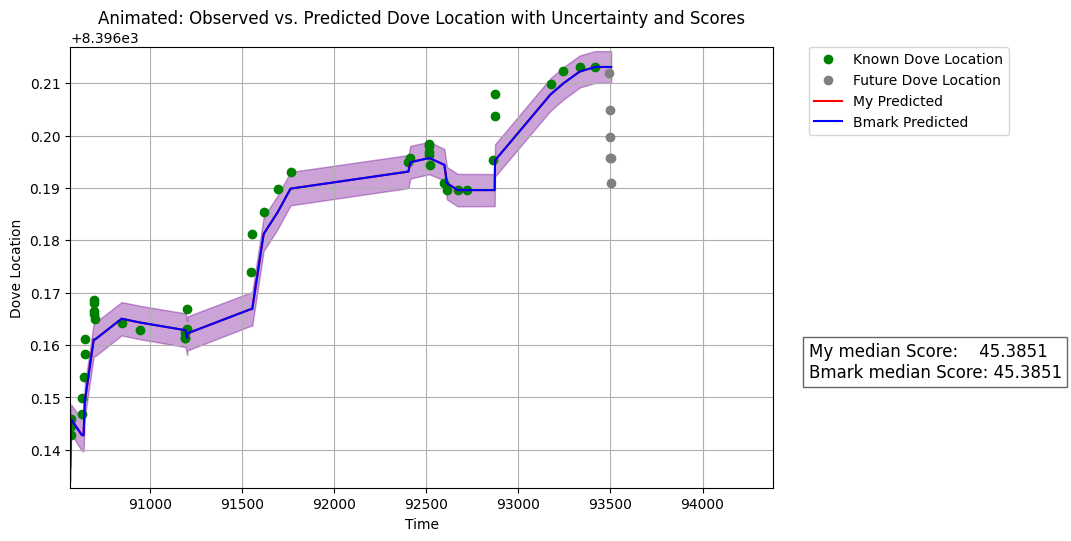

In [ ]:
%matplotlib inline
from IPython.display import HTML

class Constants:
    HORIZON = 10
    FADE_FACTOR = 0.0001

tracker = EMWAVarTracker(fading_factor=Constants.FADE_FACTOR, horizon=Constants.HORIZON)

animated = tracker.test_run_animated(live=False, from_notebook=True)

# Display animation in notebook
HTML(animated.to_jshtml())
# Interrupt cell to stop run